ANALYZING RQ2: Repository Popularity vs. PR Decision Time
Data loading successful: 859927 row, 26 column

 Check data columns...
Available columns: ['id_x', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url', 'id_y', 'url', 'license', 'full_name', 'language', 'forks', 'stars', 'agent_name', 'is_merged', 'decision_time_hours', 'body_word_count', 'language_grouped']
Possible sequence of stars: ['stars']
Possible date columns: ['created_at', 'closed_at', 'decision_time_hours']

Clean and transform data...
After removing missing values: 859927 row (delete 0 row)
Date conversion successful
Decision-making time statistics:
  average value: 3.21 hours
  median: 0.01 hours
  Standard Deviation: 18.51 hours

Star count:
  Minimum value: 0.0
  Maximum value: 177379.0
  median: 0.0
  average value: 149.52

Calculate correlation...
Pearson correlation coefficient: 0.149 (p-value: 0.0000e+00)
Spearman correlation

/var/folders/7g/570cwlg916g7pmb2m8x7h7zw0000gn/T/ipykernel_51126/2231600554.py:141: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df_clean.groupby('stars_bin').agg({


The chart has been saved: rq2_correlation.png


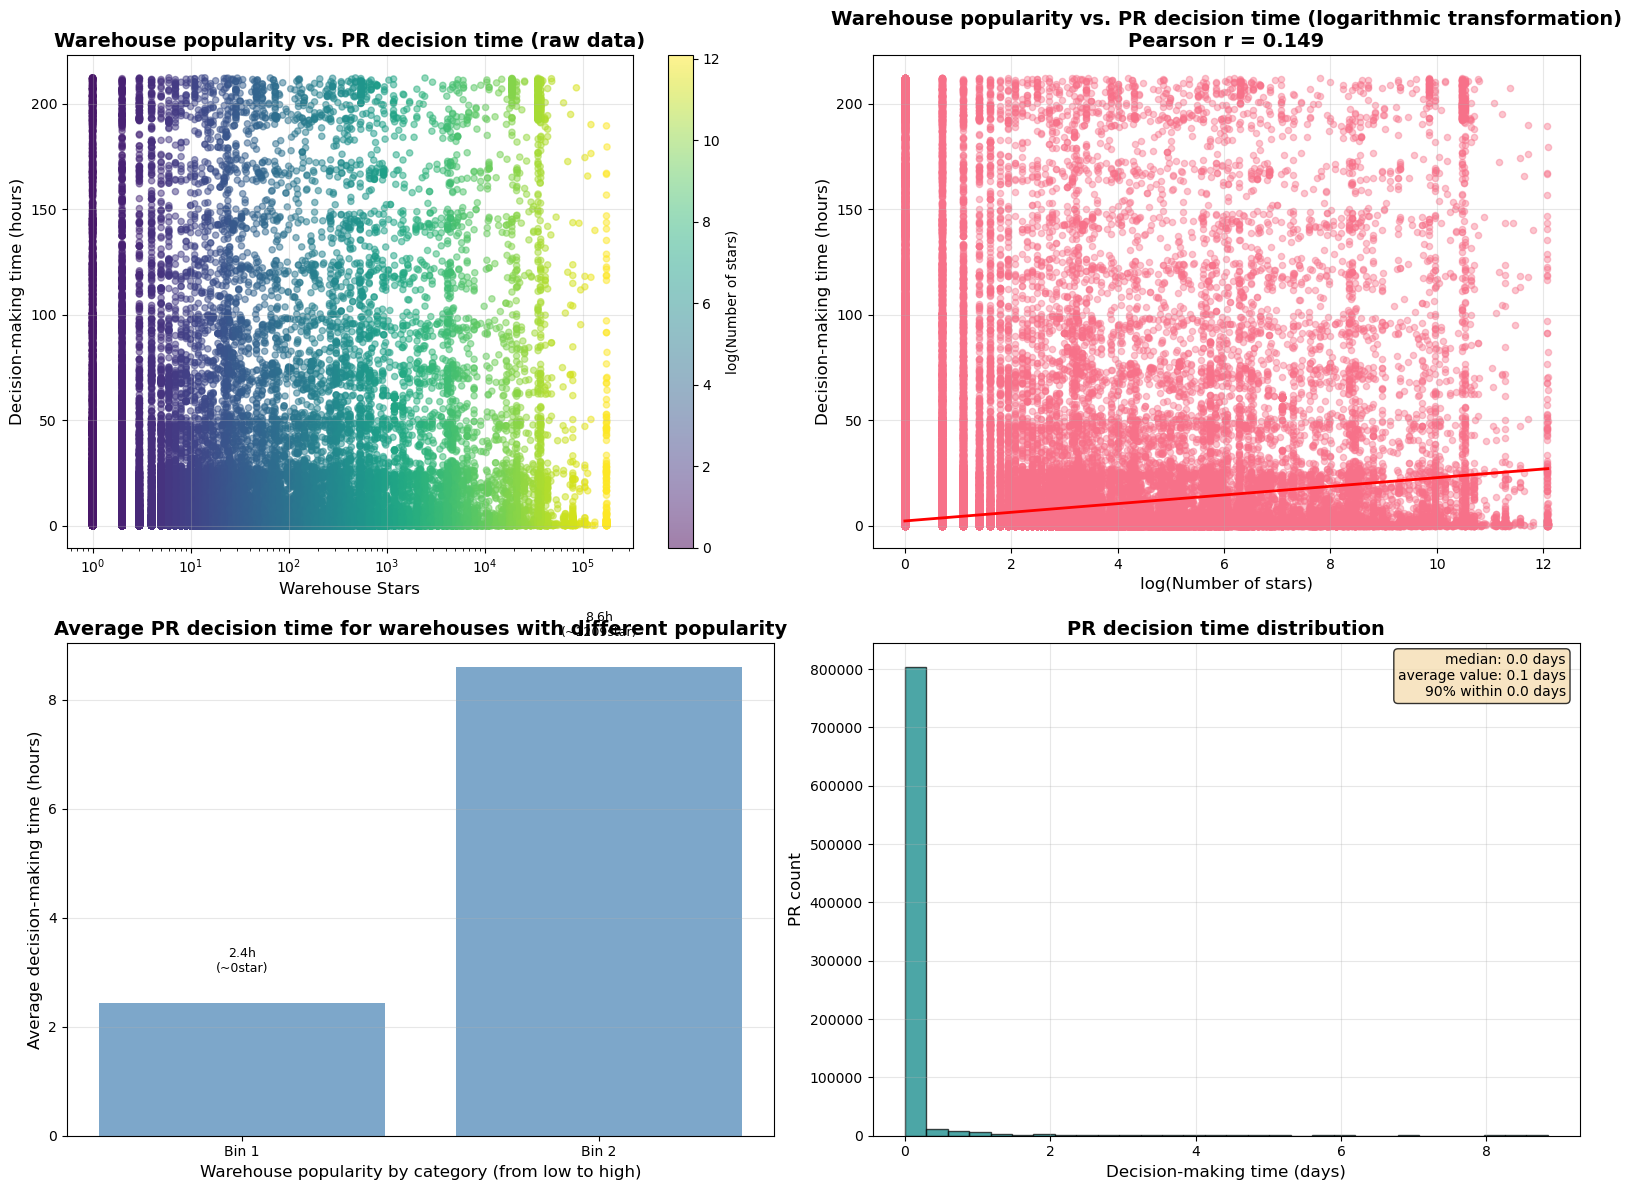


RQ2 Analysis Conclusion
Correlation analysis:
   • Warehouse popularity was not significantly correlated with PR decision time.
   • Pearson correlation coefficient: 0.149
   • This indicates that the popularity of a warehouse has no systematic impact on PR decision time.

Key findings:
  1. Average PR decision time: 3.2 hours
  2. 50% of PRs are processed within 0.0 days
  3. 90% of PRs are processed within 0.0 days
  4. Average decision time of most popular warehouses: 8.6 hours
  5. Average decision time for the least popular warehouse: 2.4 hours


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from datetime import datetime
from scipy import stats

def analyze_rq2(input_file='cleaned_data.csv', output_image='rq2_correlation.png'):
    """
    RQ2: Analyze the correlation between warehouse popularity (Stars) and AI-generated PR decision time.
    """
    print("="*60)
    print("ANALYZING RQ2: Repository Popularity vs. PR Decision Time")
    print("="*60)
    
    if not os.path.exists(input_file):
        print(f"ERROR: File '{input_file}' does not exist.")
        print("Please run cleaning.py first to generate the cleaned data.")
        return False
    
    df = pd.read_csv(input_file)
    print(f"Data loading successful: {df.shape[0]} row, {df.shape[1]} column")
    
    print("\n Check data columns...")
    print(f"Available columns: {list(df.columns)}")
    
    stars_cols = [col for col in df.columns if 'star' in col.lower()]
    date_cols = [col for col in df.columns if any(x in col.lower() for x in ['date', 'time', 'created', 'closed'])]
    
    print(f"Possible sequence of stars: {stars_cols}")
    print(f"Possible date columns: {date_cols}")
    
    if stars_cols:
        df.rename(columns={stars_cols[0]: 'stars'}, inplace=True)
    elif 'stars' not in df.columns and 'repo_stars' in df.columns:
        df.rename(columns={'repo_stars': 'stars'}, inplace=True)
    elif 'stars' not in df.columns:
        print("Error: Warehouse star sequence not found.")
        return False
    
    date_mapping = {
        'created_at': ['created_at', 'created', 'opened_at', 'opened'],
        'closed_at': ['closed_at', 'closed', 'merged_at', 'merged', 'ended_at']
    }
    
    for target_col, possible_cols in date_mapping.items():
        if target_col not in df.columns:
            for col in possible_cols:
                if col in df.columns:
                    df.rename(columns={col: target_col}, inplace=True)
                    print(f"Use '{col}' as {target_col}")
                    break
    
    required_cols = ['stars', 'created_at', 'closed_at']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"Required columns missing: {missing_cols}")
        return False
    
    print("\nClean and transform data...")
    
    initial_rows = len(df)
    df = df.dropna(subset=['created_at', 'closed_at', 'stars'])
    print(f"After removing missing values: {len(df)} row (delete {initial_rows - len(df)} row)")
    
    if len(df) == 0:
        print("Error: No valid data found after cleanup")
        return False
    
    try:
        df['created_at'] = pd.to_datetime(df['created_at'])
        df['closed_at'] = pd.to_datetime(df['closed_at'])
        print("Date conversion successful")
    except Exception as e:
        print(f"Date conversion failed: {e}")
        return False
    
    df['decision_time_hours'] = (df['closed_at'] - df['created_at']).dt.total_seconds() / 3600
    df['decision_time_days'] = df['decision_time_hours'] / 24
    
    q99_time = df['decision_time_hours'].quantile(0.99)
    df_clean = df[df['decision_time_hours'] <= q99_time].copy()
    
    print(f"Decision-making time statistics:")
    print(f"  average value: {df_clean['decision_time_hours'].mean():.2f} hours")
    print(f"  median: {df_clean['decision_time_hours'].median():.2f} hours")
    print(f"  Standard Deviation: {df_clean['decision_time_hours'].std():.2f} hours")
    
    print(f"\nStar count:")
    print(f"  Minimum value: {df_clean['stars'].min()}")
    print(f"  Maximum value: {df_clean['stars'].max()}")
    print(f"  median: {df_clean['stars'].median()}")
    print(f"  average value: {df_clean['stars'].mean():.2f}")
    
    df_clean['log_stars'] = np.log1p(df_clean['stars'])
    df_clean['log_decision_hours'] = np.log1p(df_clean['decision_time_hours'])
    
    print("\nCalculate correlation...")
    
    pearson_corr, p_value_pearson = stats.pearsonr(df_clean['log_stars'], df_clean['decision_time_hours'])
    print(f"Pearson correlation coefficient: {pearson_corr:.3f} (p-value: {p_value_pearson:.4e})")
    
    spearman_corr, p_value_spearman = stats.spearmanr(df_clean['stars'], df_clean['decision_time_hours'])
    print(f"Spearman correlation coefficient: {spearman_corr:.3f} (p-value: {p_value_spearman:.4e})")
    
    print("\nGenerate visual charts...")
    
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    ax1 = axes[0, 0]
    scatter1 = ax1.scatter(df_clean['stars'], df_clean['decision_time_hours'], 
                          alpha=0.5, s=20, c=df_clean['log_stars'], cmap='viridis')
    ax1.set_xlabel('Warehouse Stars', fontsize=12)
    ax1.set_ylabel('Decision-making time (hours)', fontsize=12)
    ax1.set_title('Warehouse popularity vs. PR decision time (raw data)', fontsize=14, fontweight='bold')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    
    plt.colorbar(scatter1, ax=ax1, label='log(Number of stars)')
    
    ax2 = axes[0, 1]
    sns.regplot(x='log_stars', y='decision_time_hours', data=df_clean,
                scatter_kws={'alpha': 0.4, 's': 20},
                line_kws={'color': 'red', 'linewidth': 2},
                ax=ax2)
    ax2.set_xlabel('log(Number of stars)', fontsize=12)
    ax2.set_ylabel('Decision-making time (hours)', fontsize=12)
    ax2.set_title(f'Warehouse popularity vs. PR decision time (logarithmic transformation)\nPearson r = {pearson_corr:.3f}', 
                 fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    ax3 = axes[1, 0]
    
    df_clean['stars_bin'] = pd.qcut(df_clean['stars'], q=5, duplicates='drop')
    
    bin_stats = df_clean.groupby('stars_bin').agg({
        'decision_time_hours': 'mean',
        'stars': 'mean',
        'log_stars': 'mean'
    }).reset_index()
    
    bars = ax3.bar(range(len(bin_stats)), bin_stats['decision_time_hours'], 
                  color='steelblue', alpha=0.7)
    ax3.set_xlabel('Warehouse popularity by category (from low to high)', fontsize=12)
    ax3.set_ylabel('Average decision-making time (hours)', fontsize=12)
    ax3.set_title('Average PR decision time for warehouses with different popularity', fontsize=14, fontweight='bold')
    ax3.set_xticks(range(len(bin_stats)))
    ax3.set_xticklabels([f'Bin {i+1}' for i in range(len(bin_stats))])
    ax3.grid(True, alpha=0.3, axis='y')
    
    for i, (bar, stat) in enumerate(zip(bars, bin_stats['stars'].astype(int))):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}h\n(~{stat:.0f}star)',
                ha='center', va='bottom', fontsize=9)
    
    ax4 = axes[1, 1]
    
    decision_days = df_clean['decision_time_days']
    
    n, bins, patches = ax4.hist(decision_days, bins=30, alpha=0.7, 
                               color='teal', edgecolor='black')
    ax4.set_xlabel('Decision-making time (days)', fontsize=12)
    ax4.set_ylabel('PR count', fontsize=12)
    ax4.set_title('PR decision time distribution', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    stats_text = (f"median: {decision_days.median():.1f} days\n"
                 f"average value: {decision_days.mean():.1f} days\n"
                 f"90% within {decision_days.quantile(0.9):.1f} days")
    ax4.text(0.98, 0.98, stats_text, transform=ax4.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)
    
    plt.tight_layout()
    
    plt.savefig(output_image, dpi=300, bbox_inches='tight')
    print(f"The chart has been saved: {output_image}")
    
    plt.show()
    
    print("\n" + "="*60)
    print("RQ2 Analysis Conclusion")
    print("="*60)
    
    if abs(pearson_corr) > 0.3:
        direction = "Positive correlation" if pearson_corr > 0 else "negative correlation"
        strength = "Strong" if abs(pearson_corr) > 0.7 else "Medium" if abs(pearson_corr) > 0.3 else "Weak"
        print(f"Correlation analysis:")
        print(f"   • Warehouse popularity and PR decision time exist{strength}{direction}")
        print(f"   • Pearson correlation coefficient: {pearson_corr:.3f}")
        
        if pearson_corr > 0:
            print(f"   • This means that the more stars a repository has, the longer its PR decision-making time may be.")
        else:
            print(f"   • This means that warehouses with more stars may have shorter PR decision-making times.")
    else:
        print(f"Correlation analysis:")
        print(f"   • Warehouse popularity was not significantly correlated with PR decision time.")
        print(f"   • Pearson correlation coefficient: {pearson_corr:.3f}")
        print(f"   • This indicates that the popularity of a warehouse has no systematic impact on PR decision time.")
    
    print(f"\nKey findings:")
    print(f"  1. Average PR decision time: {df_clean['decision_time_hours'].mean():.1f} hours")
    print(f"  2. 50% of PRs are processed within {df_clean['decision_time_days'].median():.1f} days")
    print(f"  3. 90% of PRs are processed within {df_clean['decision_time_days'].quantile(0.9):.1f} days")
    print(f"  4. Average decision time of most popular warehouses: {bin_stats.iloc[-1]['decision_time_hours']:.1f} hours")
    print(f"  5. Average decision time for the least popular warehouse: {bin_stats.iloc[0]['decision_time_hours']:.1f} hours")
    
    return True

if __name__ == "__main__":
    analyze_rq2('cleaned_data.csv', 'rq2_correlation.png')